## Intro fig et qualtitatif 

In [2]:
import os
import torchvision.transforms as transforms
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings('ignore')
from lscaleuq.models.clip import load as load_clip
from lscaleuq.models.clip import tokenize as clip_tokenize
from lscaleuq.models import ConfidNetVLMAttention
from lscaleuq.dataset_uq.utils import ConvertImageToRGB  
from lscaleuq.dataset_uq import Flowers102Dataset
import lscaleuq.lib as lib


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
confidnet_path = '/users/k/karmimy/These/large_scale_uq/weights/confidnet_flowers.ckpt'
uqvlm_path = '/users/k/karmimy/These/large_scale_uq/weights/uq_vlm_flowers.ckpt'
visu_path = '/users/k/karmimy/These/large_scale_uq/visu/flowers'
os.makedirs(visu_path,exist_ok=True)
dataset = 'Flowers102'
val_transforms = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),  # interpolation=3 correspond à BICUBIC
    transforms.CenterCrop(224),
    ConvertImageToRGB(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073],
        std=[0.26862954, 0.26130258, 0.27577711]
    )
])

dts_val = Flowers102Dataset('/local/DEEPLEARNING/dataset_suite/flowers102',split='test',transform=val_transforms)

In [5]:
clip_model, _ = load_clip("ViT-B/32")
clip_model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [6]:

confidnet = ConfidNetVLMAttention(
                                        concat=True,
                                        identity_init=True,
                                        n_iter_freeze_proj=1000,
                                        keep_frozen=True,
                                        use_predicted_caption=False,
                                        use_attention=False,
                                        )

uqvlm = ConfidNetVLMAttention(
                                        concat=True,
                                        identity_init=True,
                                        n_iter_freeze_proj=1000,
                                        keep_frozen=True,
                                        use_predicted_caption=True,
                                        use_attention=True,
                                        )


template = "A photo of a {}."
logit_scale = uqvlm.logit_scale

In [7]:
confidnet.load_state_dict(torch.load(confidnet_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')['state_dict'])
uqvlm.load_state_dict(torch.load(uqvlm_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')['state_dict'])
confidnet.to(device)
uqvlm.to(device)
confidnet.eval()
uqvlm.eval()

ConfidNetVLMAttention(
  (activation_fn): ReLU()
  (mlp): Sequential(
    (0): Linear(in_features=1536, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (in_proj_v): Linear(in_features=512, out_features=512, bias=False)
  (in_proj_t): Linear(in_features=512, out_features=512, bias=False)
)

### Calcul du seuil

In [8]:
NB_IMAGES = 100000
need_treshold = False


In [10]:

dataloader_val = DataLoader(dts_val, batch_size=128, shuffle=False, num_workers=4)

### Compute treshold FPR for imagenet (MCM,Confidnet and UQVLM)

In [11]:

if need_treshold:
    confidnet_success = []
    confidnet_failure = []
    uqvlm_success = []
    uqvlm_failure = []
    missclassifieds = []
    tcps_success = []
    tcps_failure = []
    mcps_success = []
    mcps_failure = []
    total_iter = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader_train):
            if total_iter >= NB_IMAGES:
                break
            total_iter += 512
            images = batch["image"]
            labels = batch["target"].to(device)
            visual_feats = clip_model.encode_image(images.to(device))
            visual_feats /= visual_feats.norm(dim=-1, keepdim=True)
            class_names = dataloader_val.dataset.class_names
            class_names = clip_tokenize([template.format(name) for name in class_names])
            text_feats = clip_model.encode_text(class_names.to(device))
            text_feats /= text_feats.norm(dim=-1, keepdim=True)

            probs = torch.softmax(logit_scale * visual_feats @ text_feats.t(), dim=-1)
            with torch.autocast(device_type='cuda'):
                confidnet_scores = confidnet(visual_feats, text_feats).squeeze(-1)
                uqvlm_scores = uqvlm(visual_feats, text_feats).squeeze(-1)

            missclassified = labels != probs.argmax(dim=-1)

            tcps = probs[torch.arange(labels.size(0)), labels]
            mcps = probs.max(dim=-1).values

            confidnet_success.append(confidnet_scores[~missclassified])
            confidnet_failure.append(confidnet_scores[missclassified])
            uqvlm_success.append(uqvlm_scores[~missclassified])
            uqvlm_failure.append(uqvlm_scores[missclassified])
            missclassifieds.append(missclassified)

            tcps_success.append(tcps[~missclassified])
            tcps_failure.append(tcps[missclassified])
            mcps_success.append(mcps[~missclassified])
            mcps_failure.append(mcps[missclassified])
        confidnet_success = torch.cat(confidnet_success).cpu().numpy()
        confidnet_failure = torch.cat(confidnet_failure).cpu().numpy()
        uqvlm_success = torch.cat(uqvlm_success).cpu().numpy()
        uqvlm_failure = torch.cat(uqvlm_failure).cpu().numpy()
        tcps_success = torch.cat(tcps_success).float().cpu().numpy()
        tcps_failure = torch.cat(tcps_failure).float().cpu().numpy()
        mcps_success = torch.cat(mcps_success).float().cpu().numpy()
        mcps_failure = torch.cat(mcps_failure).float().cpu().numpy()

        CONFIDNET_TRESHOLD_FPR = np.percentile(confidnet_success, 95)
        UQVLM_TRESHOLD_FPR = np.percentile(uqvlm_success, 95)
        MCM_TRESHOLD_FPR = np.percentile(mcps_success, 95)

### Val Image

In [12]:
confidnet_success = []
confidnet_failure = []
uqvlm_success = []
uqvlm_failure = []
missclassifieds = []
tcps_success = []
tcps_failure = []
mcps_success = []
mcps_failure = []
total_iter = 0
with torch.no_grad():
    class_names = dataloader_val.dataset.class_names
    class_names = clip_tokenize([template.format(name) for name in class_names])
    for i, batch in enumerate(dataloader_val):
        images = batch["image"]
        labels = batch["target"].to(device)
        visual_feats = clip_model.encode_image(images.to(device))
        visual_feats /= visual_feats.norm(dim=-1, keepdim=True)
        
        text_feats = clip_model.encode_text(class_names.to(device))
        text_feats /= text_feats.norm(dim=-1, keepdim=True)

        probs = torch.softmax(logit_scale * visual_feats @ text_feats.t(), dim=-1)
        with torch.autocast(device_type='cuda'):
            confidnet_scores = confidnet(visual_feats, text_feats).squeeze(-1)
            uqvlm_scores = uqvlm(visual_feats, text_feats).squeeze(-1)

        missclassified = labels != probs.argmax(dim=-1)

        tcps = probs[torch.arange(labels.size(0)), labels]
        mcps = probs.max(dim=-1).values

        confidnet_success.append(confidnet_scores[~missclassified])
        confidnet_failure.append(confidnet_scores[missclassified])
        uqvlm_success.append(uqvlm_scores[~missclassified])
        uqvlm_failure.append(uqvlm_scores[missclassified])
        missclassifieds.append(missclassified)

        tcps_success.append(tcps[~missclassified])
        tcps_failure.append(tcps[missclassified])
        mcps_success.append(mcps[~missclassified])
        mcps_failure.append(mcps[missclassified])
    
    missclassifieds = torch.cat(missclassifieds).cpu().numpy()
    confidnet_success_sigmoid = torch.sigmoid(torch.cat(confidnet_success)).cpu().numpy()
    confidnet_failure_sigmoid = torch.sigmoid(torch.cat(confidnet_failure)).cpu().numpy()
    uqvlm_success_sigmoid = torch.sigmoid(torch.cat(uqvlm_success)).cpu().numpy()
    uqvlm_failure_sigmoid = torch.sigmoid(torch.cat(uqvlm_failure)).cpu().numpy()
    confidnet_success = torch.cat(confidnet_success).cpu().numpy()
    confidnet_failure = torch.cat(confidnet_failure).cpu().numpy()
    uqvlm_success = torch.cat(uqvlm_success).cpu().numpy()
    uqvlm_failure = torch.cat(uqvlm_failure).cpu().numpy()
    tcps_success = torch.cat(tcps_success).float().cpu().numpy()
    tcps_failure = torch.cat(tcps_failure).float().cpu().numpy()
    mcps_success = torch.cat(mcps_success).float().cpu().numpy()
    mcps_failure = torch.cat(mcps_failure).float().cpu().numpy()

    fpr_confidnet = lib.get_fpr(confidnet_success, confidnet_failure)
    auc_confidnet = lib.get_auroc(confidnet_success, confidnet_failure)

    fpr_uqvlm = lib.get_fpr(uqvlm_success, uqvlm_failure)
    auc_uqvlm = lib.get_auroc(uqvlm_success, uqvlm_failure)

    fpr_mcm = lib.get_fpr(mcps_success, mcps_failure)
    auc_mcm = lib.get_auroc(mcps_success, mcps_failure)


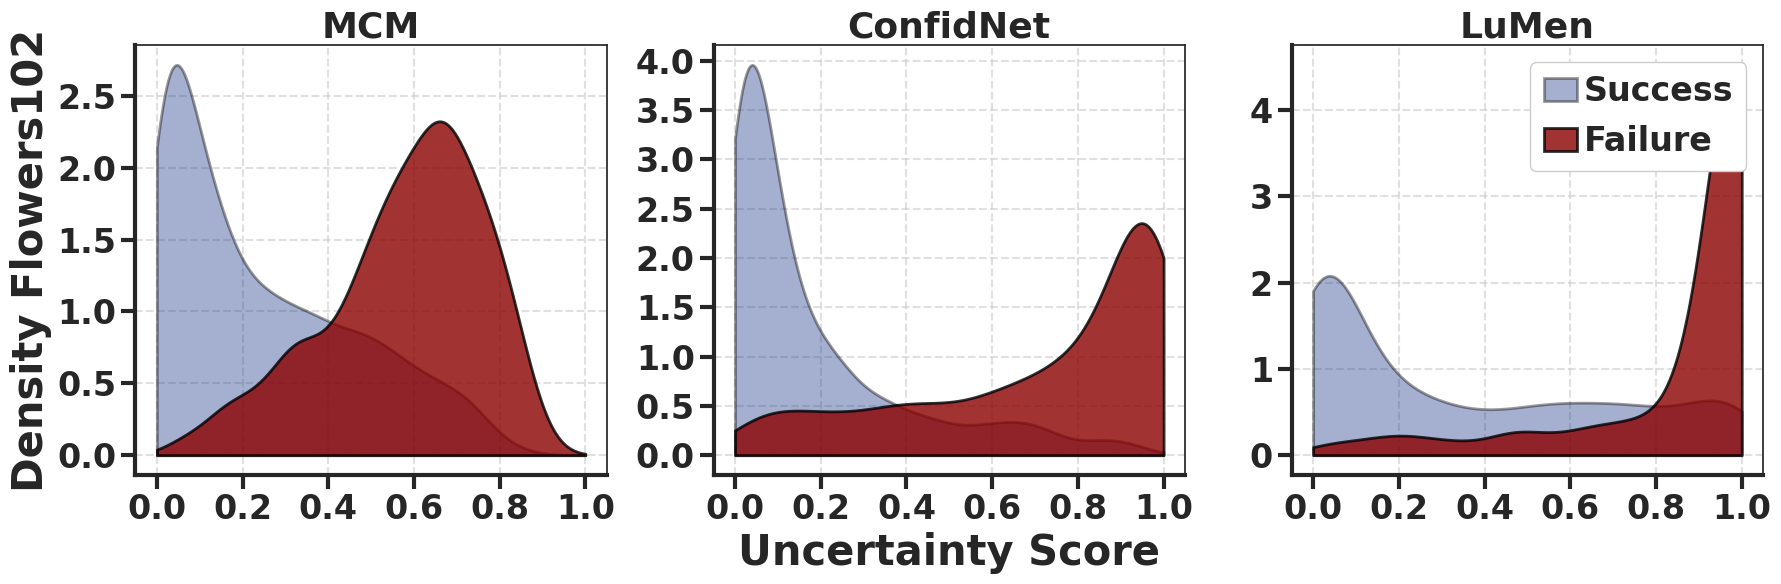

In [13]:
def plot_gaussian_distributions(mcps_success, mcps_failure, 
                                confidnet_success, confidnet_failure, 
                                uqvlm_success, uqvlm_failure):
    """
    Trace les distributions gaussiennes pour MCM, ConfidNet et UQ-VLM en sous-graphiques.

    Paramètres :
        mcps_success, mcps_failure : données pour MCM
        confidnet_success, confidnet_failure : données pour ConfidNet
        uqvlm_success, uqvlm_failure : données pour UQ-VLM
    """

    # Configuration des polices et du style
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = ["Nimbus Sans"]
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['axes.labelsize'] = 24  # Taille des titres des axes
    plt.rcParams['xtick.labelsize'] = 26  # Taille des valeurs sur l'axe X
    plt.rcParams['ytick.labelsize'] = 26  # Taille des valeurs sur l'axe Y
    sns.set_theme(style="ticks")

    # Définition des couleurs fixes pour tous les modèles
    success_color = "#1E3A8A"  # Bleu (Success)
    failure_color = "#8B0000"  # Rouge (Failure)

    methods = [
        (mcps_success, mcps_failure, "MCM"),
        (confidnet_success, confidnet_failure, "ConfidNet"),
        (uqvlm_success, uqvlm_failure, "LuMen")
    ]
    
    plt.figure(figsize=(18, 6))

    for i, (success, failure, method) in enumerate(methods):
        plt.subplot(1, 3, i + 1)

        # Estimation de la densité
        success_kde = gaussian_kde(success)
        failure_kde = gaussian_kde(failure)

        # Axe de valeurs pour les courbes
        x_vals = np.linspace(0, 1, 300)

        # Calcul des densités
        success_density = success_kde(x_vals)
        failure_density = failure_kde(x_vals)

        # Tracé des courbes
        plt.fill_between(x_vals, success_density, color=success_color, alpha=0.4, 
                         edgecolor='black', linewidth=2, label="Success")
        plt.fill_between(x_vals, failure_density, color=failure_color, alpha=0.8, 
                         edgecolor='black', linewidth=2, label="Failure")

        # Titre du modèle
        plt.title(f"{method}", fontsize=26, fontweight='bold')

        # Labels des axes (le titre ne change pas de taille)
        if i == 1:
            plt.xlabel("Uncertainty Score", fontsize=30, fontweight='bold')
        if i == 0:  # Ajout du label Density uniquement sur le premier subplot
            plt.ylabel("Density "+dataset, fontsize=30, fontweight='bold')

        # Personnalisation des axes
        ax = plt.gca()
        ax.spines['bottom'].set_linewidth(3)  # Axe X
        ax.spines['left'].set_linewidth(3)    # Axe Y
        ax.tick_params(axis='x', which='major', width=3, length=10)  # Axe X (Uncertainty Score)
        ax.tick_params(axis='y', which='major', width=3, length=10)  # Axe Y (Density)
        

        # Rendre les ticks plus visibles et gras
        for tick in ax.get_xticklabels() + ax.get_yticklabels():
            tick.set_fontweight('bold')
            tick.set_fontsize(24)

        plt.grid(True, linestyle="--", linewidth=1.5, alpha=0.6)

    plt.legend(fontsize=24, loc='upper right', framealpha=1, handletextpad=0.2, 
               columnspacing=0.4, handlelength=1)

    plt.tight_layout()
    save_path = f"{visu_path}/failure_{dataset}.png"
    plt.savefig(save_path, dpi=300)
    plt.show()

plot_gaussian_distributions(1 - mcps_success, 1 - mcps_failure, 1 - confidnet_success_sigmoid, 1 - confidnet_failure_sigmoid, 1 - uqvlm_success_sigmoid, 1 - uqvlm_failure_sigmoid)

In [25]:
CONFIDNET_TRESHOLD_FPR = np.percentile(confidnet_success, 60)
UQVLM_TRESHOLD_FPR = np.percentile(uqvlm_success, 60)
MCM_TRESHOLD_FPR = np.percentile(mcps_success, 60)

In [26]:
index_fail = []
indices =  np.where(missclassifieds)[0]
cpt_mcm = 0
cpt_confidnet = 0
cpt_uqvlm = 0
for i in range(mcps_failure.shape[0]):
    if mcps_failure[i] > MCM_TRESHOLD_FPR and confidnet_failure[i] > CONFIDNET_TRESHOLD_FPR and uqvlm_failure[i] < UQVLM_TRESHOLD_FPR:
        index_fail.append(i)

index_images = indices[index_fail]

In [27]:
index_images

array([], dtype=int64)

In [28]:
clip_pred = {}
class_names = dataloader_val.dataset.class_names
with torch.no_grad():
    for i in index_images:
        images = dts_val[i]["image"].unsqueeze(0)
        labels = torch.tensor(dts_val[i]["target"],dtype=torch.long).to(device)
        visual_feats = clip_model.encode_image(images.to(device))
        visual_feats /= visual_feats.norm(dim=-1, keepdim=True)
        class_names = dataloader_val.dataset.class_names
        class_names_tokenize = clip_tokenize([template.format(name) for name in class_names])
        text_feats = clip_model.encode_text(class_names_tokenize.to(device))
        text_feats /= text_feats.norm(dim=-1, keepdim=True)
        probs = torch.softmax(logit_scale * visual_feats @ text_feats.t(), dim=-1)
        
        clip_pred[i] = {"index": i, "true_class": class_names[labels], "pred_class": class_names[probs.argmax(dim=-1).item()]}

In [ ]:
clip_pred

In [ ]:
dts_val = CIFAR10Dataset('/local/DEEPLEARNING/LargeScaleUQ/CIFAR-10',train=False,transform=None)


def display_images_with_labels(dataset, indices, clip_pred, num_images=10):
    """
    Affiche les images mal classifiées en indiquant clairement que MCM et ConfidNet n'ont pas détecté l'erreur,
    mais que UQ-VLM l'a détectée.

    Paramètres :
        dataset (ImageNetDataset) : Le dataset contenant les images.
        indices (list) : Liste des indices des images à afficher.
        clip_pred (dict) : Dictionnaire contenant les informations des prédictions.
        num_images (int) : Nombre d'images à afficher (par défaut 10).
    """
    num_images = min(num_images, len(indices))  
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 4))

    # Ajouter un titre principal sur la figure

    for ax, idx in zip(axes, indices[:num_images]):
        data = dataset[idx]  # Récupérer l'image non normalisée
        img = data["image"]

        # Récupérer labels
        true_label = clip_pred[idx]['true_class']
        pred_label = clip_pred[idx]['pred_class']

        # Affichage de l'image
        ax.imshow(img)
        ax.set_title(f"GT: {true_label}\nPred: {pred_label}\n(MCM: No failure)\n(ConfidNet: No failure)\n(UQ-VLM: Failure)", fontsize=10, color="black")
        ax.axis("off")

    plt.tight_layout()
    plt.show()



In [ ]:
display_images_with_labels(dts_val, index_images, clip_pred, num_images=4)